In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 7.5 # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 30
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

150000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

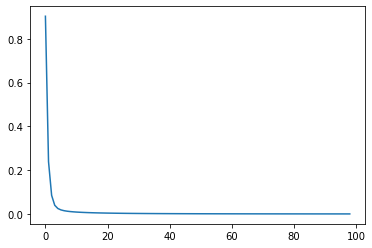

In [8]:
plt.plot(S)

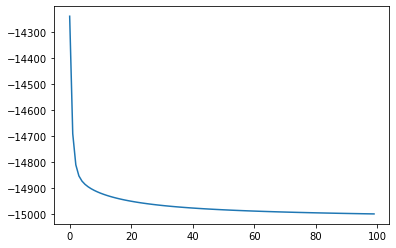

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.00037445639648649376

In [11]:
eta

array([-14240.16545866, -14691.38440198, -14810.84325041, -14853.35843873,
       -14873.28010961, -14885.83817183, -14895.17280489, -14902.71301941,
       -14909.09134447, -14914.64102064, -14919.56028473, -14923.97793545,
       -14927.98338798, -14931.64196358, -14935.00332521, -14938.10644539,
       -14940.98269336, -14943.65784227, -14946.1534258 , -14948.48768614,
       -14950.67625614, -14952.73266278, -14954.66870741, -14956.49475847,
       -14958.21998106, -14959.85251963, -14961.3996455 , -14962.86787737,
       -14964.2630809 , -14965.59055177, -14966.85508557, -14968.06103701,
       -14969.21237057, -14970.31270387, -14971.36534532, -14972.37332664,
       -14973.33943133, -14974.26621958, -14975.1560502 , -14976.01109993,
       -14976.83338054, -14977.62475409, -14978.38694644, -14979.12155933,
       -14979.8300812 , -14980.51389693, -14981.17429653, -14981.81248304,
       -14982.42957959, -14983.02663586, -14983.60463384, -14984.16449316,
       -14984.70707586, -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([7.59234542e+02, 3.08015599e+02, 1.88556751e+02, 1.46041562e+02,
       1.26119891e+02, 1.13561829e+02, 1.04227196e+02, 9.66869817e+01,
       9.03086566e+01, 8.47589804e+01, 7.98397163e+01, 7.54220656e+01,
       7.14166131e+01, 6.77580375e+01, 6.43966759e+01, 6.12935557e+01,
       5.84173077e+01, 5.57421588e+01, 5.32465753e+01, 5.09123149e+01,
       4.87237449e+01, 4.66673383e+01, 4.47312937e+01, 4.29052426e+01,
       4.11800200e+01, 3.95474814e+01, 3.80003556e+01, 3.65321237e+01,
       3.51369202e+01, 3.38094493e+01, 3.25449155e+01, 3.13389641e+01,
       3.01876305e+01, 2.90872972e+01, 2.80346557e+01, 2.70266744e+01,
       2.60605697e+01, 2.51337815e+01, 2.42439509e+01, 2.33889011e+01,
       2.25666205e+01, 2.17752470e+01, 2.10130546e+01, 2.02784417e+01,
       1.95699199e+01, 1.88861041e+01, 1.82257045e+01, 1.75875180e+01,
       1.69704215e+01, 1.63733652e+01, 1.57953672e+01, 1.52355079e+01,
       1.46929252e+01, 1.41668103e+01, 1.36564037e+01, 1.31609913e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_7.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_7.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_7.csv', S, delimiter = ',')